In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
from tqdm import tqdm
import json

## 1. Data Collection and Preprocessing

In [ ]:
def extract_landmarks(image_path):
    """Extract hand landmarks from an image using MediaPipe"""
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5
    )

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image
    results = hands.process(image_rgb)

    # Extract landmarks
    landmarks = []
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])

    hands.close()
    return landmarks if landmarks else None

In [ ]:
def process_dataset(data_dir):
    """Process all images in the dataset directory"""
    data = []
    labels = []

    # Iterate through gesture folders
    for gesture_name in os.listdir(data_dir):
        gesture_dir = os.path.join(data_dir, gesture_name)
        if not os.path.isdir(gesture_dir):
            continue

        print(f"Processing {gesture_name}...")

        # Process each image in the gesture folder
        for image_name in tqdm(os.listdir(gesture_dir)):
            if not image_name.endswith(('.jpg', '.png')):
                continue

            image_path = os.path.join(gesture_dir, image_name)
            landmarks = extract_landmarks(image_path)

            if landmarks:
                data.append(landmarks)
                labels.append(gesture_name)

    return np.array(data), np.array(labels)

## 2. Model Training

In [ ]:
def train_model(X, y):
    """Train and evaluate the Random Forest classifier"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Initialize and train the model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Evaluate the model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)

    # Generate predictions
    y_pred = model.predict(X_test)

    return model, {
        'train_score': train_score,
        'test_score': test_score,
        'cv_scores': cv_scores,
        'y_test': y_test,
        'y_pred': y_pred
    }

## 3. Model Evaluation and Visualization

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix by khaled-rawan')
    plt.ylabel('True ')
    plt.xlabel('Predicted ')
    plt.show()

In [ ]:
def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title('Feature Importance')
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

## 4. Main Execution

In [ ]:
# Set data directory
data_dir = '/kaggle/input/hand-gesture-recognition-dataset-one-hand/Dataset_RGB/Dataset_RGB'

# Process dataset
X, y = process_dataset(data_dir)

# Train model
model, results = train_model(X, y)

# Print results
print(f"Training Score: {results['train_score']:.4f}")
print(f"Testing Score: {results['test_score']:.4f}")
print(f"Cross-validation Scores: {results['cv_scores']}")
print(f"Mean CV Score: {np.mean(results['cv_scores']):.4f}")


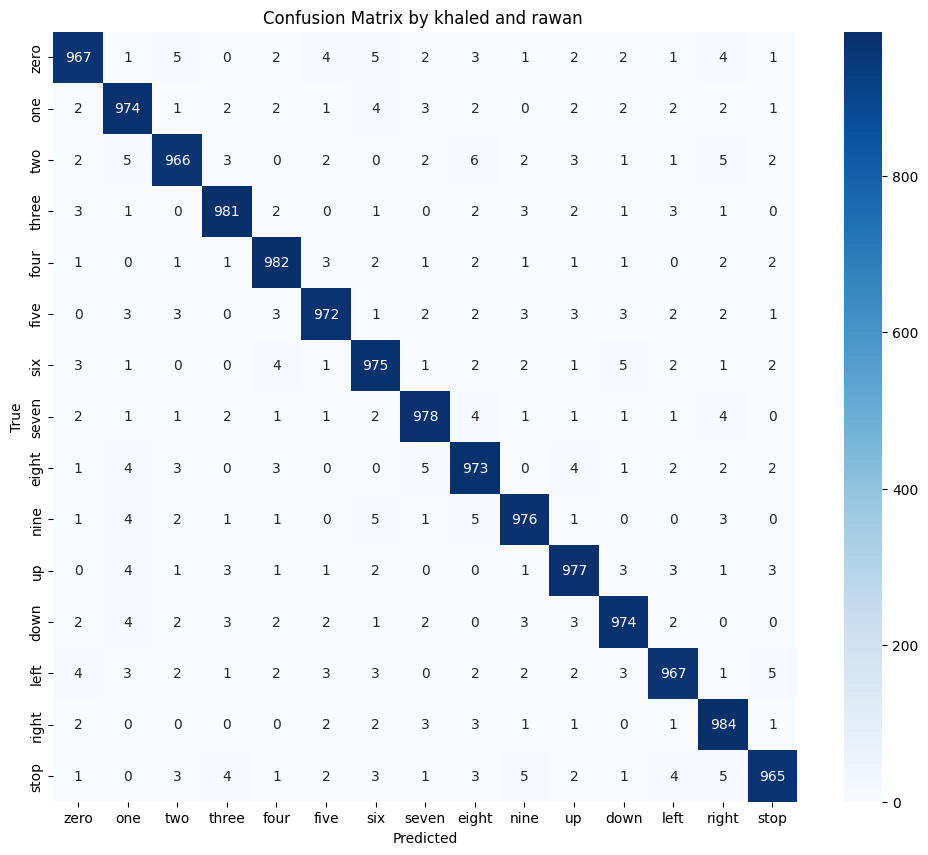

              precision    recall  f1-score   support

        zero       0.98      0.97      0.97      1000
         one       0.97      0.97      0.97      1000
         two       0.98      0.97      0.97      1000
       three       0.98      0.98      0.98      1000
        four       0.98      0.98      0.98      1000
        five       0.98      0.97      0.97      1000
         six       0.97      0.97      0.97      1000
       seven       0.98      0.98      0.98      1000
       eight       0.96      0.97      0.97      1000
        nine       0.98      0.98      0.98      1000
          up       0.97      0.98      0.97      1000
        down       0.98      0.97      0.97      1000
        left       0.98      0.97      0.97      1000
       right       0.97      0.98      0.98      1000
        stop       0.98      0.96      0.97      1000

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97   

In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(results['y_test'], results['y_pred']))

# Plot confusion matrix
plot_confusion_matrix(results['y_test'], results['y_pred'], np.unique(y))

# Save the model
os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/hand_gesture_classifier.joblib')

# Save feature names
feature_names = [f'landmark_{i}' for i in range(X.shape[1])]
plot_feature_importance(model, feature_names)